In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pyro
import pyro.optim
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from typing import Union, Tuple, Optional, Callable, Dict, Set, List
from tqdm import tnrange
from subprocess import Popen
import os
from bb_opt.src.hsic import total_hsic, dimwise_mixrq_kernels
from MNF_VBNN.mnf_net import MNFNet

# always need to use device 0 in pytorch; if you want to use, e.g., gpu 1 instead,
# make that the only visible GPU and reference it as 0 then

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
%matplotlib inline

batch_size = 200

ec50 = pd.read_csv('../data/malaria.csv').ec50.values
fingerprints = np.load('../data/fingerprints.npy')
fingerprints.shape

(18924, 512)

In [2]:
pred_std = 1

In [3]:
import time

In [12]:
epochs = 100
epzero = 1
fq = 2
fr = 2
use_z = True
seed = 521
lr = 0.001
thres_var = 0.5
flow_h = 50
L = 100
anneal = False
learn_p = False

batch_size = 100

In [13]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(fingerprints, ec50, test_size=.5)

train_inputs = torch.tensor(train_inputs).float().to(device)
train_labels = torch.tensor(train_labels).float().to(device)
train_data = TensorDataset(train_inputs, train_labels)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_inputs = torch.tensor(test_inputs).float().to(device)
test_labels = torch.tensor(test_labels).float().to(device)

N = len(train_inputs)

In [79]:
model = MNFNet(N, flows_q=fq, flows_r=fr, use_z=use_z,
               learn_p=learn_p, thres_var=thres_var, flow_dim_h=flow_h, device=device)
model.predict(train_inputs[:1]);  # initializes some parameters

In [80]:
if anneal:
    assert False
    number_zero, original_zero = epzero, epochs / 2
    max_zero_step = number_zero * iter_per_epoch
    original_anneal = original_zero * iter_per_epoch
    beta_t_val = tf.cast((tf.cast(global_step, tf.float32) - max_zero_step) / original_anneal, tf.float32)
    beta_t = tf.maximum(beta_t_val, 0.)
    annealing = tf.minimum(1., tf.cond(global_step < max_zero_step, lambda: tf.zeros((1,))[0], lambda: beta_t))
else:
    annealing = 75

optimizer = torch.optim.Adam(model.params, lr)

In [81]:
idx = list(range(N))

log_probs = []
kls = []
elbos = []
for epoch in range(epochs):
#     model.train()
    t0 = time.time()

    for batch in train_loader:
        inputs, labels = batch
        optimizer.zero_grad()

        preds = model.predict(inputs).squeeze()
        pred_dist = torch.distributions.Normal(preds, pred_std)
        log_likelihood = pred_dist.log_prob(labels).sum()
        regs = model.get_reg()  # KL divergence
        lowerbound = log_likelihood - annealing * regs
        
        log_probs.append(log_likelihood.item())
        kls.append(regs.item())
        elbos.append(lowerbound.item())

        (-lowerbound).backward()
        optimizer.step()

    if epoch % 1 == 0:
#         model.eval()
        with torch.no_grad():
            predictions = model.predict(test_inputs).squeeze()
            mse = torch.mean((predictions - test_labels) ** 2)

        print(f'[E{epoch}] Lowerbound = {np.mean(elbos[-500:]):.3f}. Test MSE = {mse.item():.3f}')

[E0] Lowerbound = -4046.842. Test MSE = 8.648
[E1] Lowerbound = -3996.419. Test MSE = 8.321
[E2] Lowerbound = -3960.667. Test MSE = 8.149
[E3] Lowerbound = -3929.692. Test MSE = 7.981
[E4] Lowerbound = -3901.389. Test MSE = 8.061
[E5] Lowerbound = -3848.204. Test MSE = 8.118
[E6] Lowerbound = -3800.542. Test MSE = 8.022
[E7] Lowerbound = -3749.898. Test MSE = 7.908
[E8] Lowerbound = -3699.996. Test MSE = 8.178
[E9] Lowerbound = -3654.685. Test MSE = 8.024
[E10] Lowerbound = -3607.169. Test MSE = 7.998
[E11] Lowerbound = -3560.582. Test MSE = 7.898
[E12] Lowerbound = -3510.861. Test MSE = 7.944
[E13] Lowerbound = -3464.603. Test MSE = 7.990
[E14] Lowerbound = -3414.081. Test MSE = 8.140
[E15] Lowerbound = -3360.712. Test MSE = 7.913
[E16] Lowerbound = -3309.166. Test MSE = 7.950
[E17] Lowerbound = -3254.388. Test MSE = 8.359
[E18] Lowerbound = -3202.216. Test MSE = 8.146
[E19] Lowerbound = -3146.557. Test MSE = 8.302
[E20] Lowerbound = -3091.404. Test MSE = 8.314
[E21] Lowerbound = -304

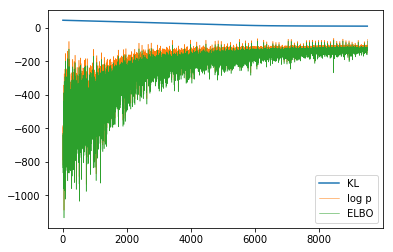

In [20]:
plt.plot(kls, label='KL')
plt.plot(log_probs, label='log p', linewidth=0.5)
plt.plot(elbos, label='ELBO', linewidth=0.5)
plt.legend()

In [83]:
preds.shape

(250, 9462)

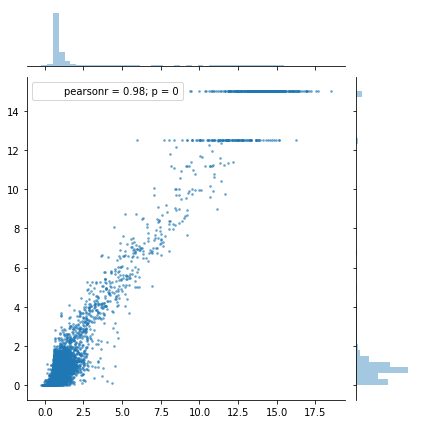

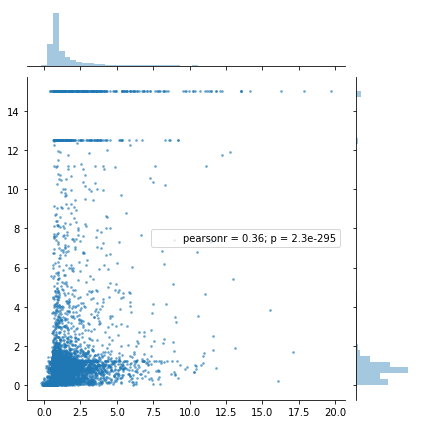

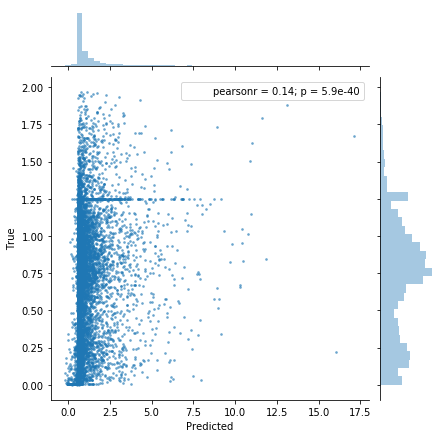

In [84]:
preds = []
with torch.no_grad():
    for _ in range(250):
        preds.append(model.predict(train_inputs).squeeze())
preds = torch.stack(preds).cpu().numpy()

sns.jointplot(preds.mean(axis=0), train_labels.cpu().numpy(), s=3, alpha=0.5)

preds = []
with torch.no_grad():
    for _ in range(250):
        preds.append(model.predict(test_inputs).squeeze())
preds = torch.stack(preds).cpu().numpy().T

sns.jointplot(preds.mean(axis=1), test_labels.cpu().numpy(), s=3, alpha=0.5)

_, sorted_idx = test_labels.sort(descending=True)
n_10_percent = int(len(test_labels) * .1)

ax = sns.jointplot(preds[sorted_idx][n_10_percent:].mean(axis=1), test_labels[sorted_idx][n_10_percent:].cpu().numpy(), s=3, alpha=0.5)
ax.set_axis_labels('Predicted', 'True')

In [24]:
i = 0

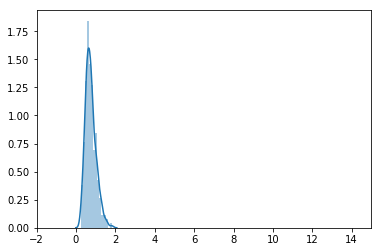

In [66]:
sns.distplot(preds[:, i])
plt.xlim(-2, 15)
i += 1

In [67]:
k = 0

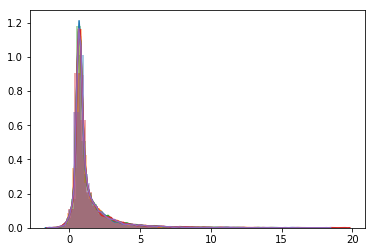

In [69]:
for l in range(5):
    sns.distplot(preds[k + l, :])
l += k + 1

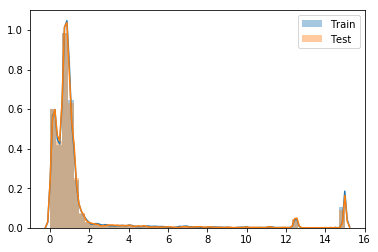

In [70]:
sns.distplot(train_labels, label="Train")
sns.distplot(test_labels, label="Test")
plt.legend();

In [71]:
percent_best = 1
inputs = test_inputs
labels = test_labels

preds = []
with torch.no_grad():
    for _ in range(250):
        preds.append(model.predict(inputs).squeeze())
preds = torch.stack(preds).cpu().numpy().T

n_best = int(percent_best / 100 * len(preds))

# sort preds by best inputs
sort_idx = labels.sort(descending=True)[1]
preds = preds[sort_idx]

mean = preds.mean(axis=1)
std = preds.std(axis=1)

x_best = list(range(n_best))
x_rest = list(range(n_best, len(mean)))

Text(0.5,1,'Mean / Std')

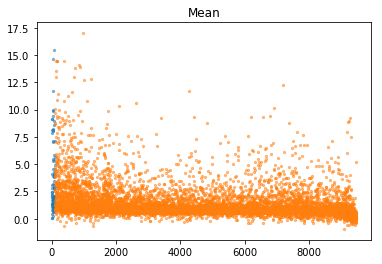

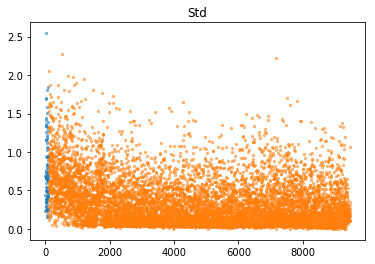

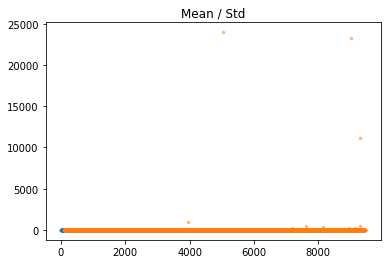

In [72]:
scatter_kwargs = {'s': 5, 'alpha': 0.5}

plt.figure()
plt.scatter(x_best, mean[:n_best], label='Best', **scatter_kwargs)
plt.scatter(x_rest, mean[n_best:], label='Rest', **scatter_kwargs)
plt.title('Mean')

plt.figure()
plt.scatter(x_best, std[:n_best], label='Best', **scatter_kwargs)
plt.scatter(x_rest, std[n_best:], label='Rest', **scatter_kwargs)
plt.title('Std')

plt.figure()
plt.scatter(x_best, mean[:n_best] / std[:n_best], label='Best', **scatter_kwargs)
plt.scatter(x_rest, mean[n_best:] / std[n_best:], label='Rest', **scatter_kwargs)
plt.title('Mean / Std')

# plt.figure()
# plt.scatter(x_best, hsic[:n_best], label='Best', **scatter_kwargs)
# plt.scatter(x_rest, hsic[n_best:], label='Rest', **scatter_kwargs)
# plt.title('HSIC')

(0, 100)

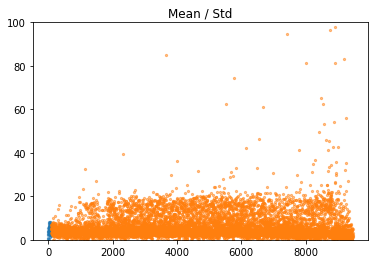

In [77]:
plt.figure()
plt.scatter(x_best, mean[:n_best] / std[:n_best], label='Best', **scatter_kwargs)
plt.scatter(x_rest, mean[n_best:] / std[n_best:], label='Rest', **scatter_kwargs)
plt.title('Mean / Std')
plt.ylim(0, 100)

Text(0.5,1,'Mean * Std')

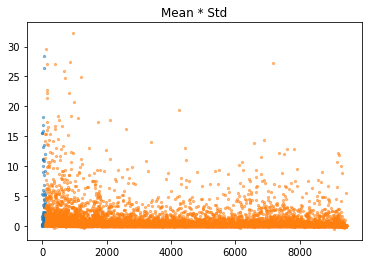

In [78]:
plt.figure()
plt.scatter(x_best, mean[:n_best] * std[:n_best], label='Best', **scatter_kwargs)
plt.scatter(x_rest, mean[n_best:] * std[n_best:], label='Rest', **scatter_kwargs)
plt.title('Mean * Std')